<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python_IDW/BaseCASE_Grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 23.6 MB/s eta 0:00:00


In [2]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.1 MB/s eta 0:00:00


# $O_{3}$

In [16]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm

# --- Load Data ---
nc_file_path = "BaseCase_PERT_O3_YEARLY.nc"
csv_file_path = "yearly_SURF_ppb_O3.csv"  # Ensure the correct CSV file is used

# Load NetCDF Data
nc_data = xr.open_dataset(nc_file_path)
lon_values = nc_data["lon"].values  # Grid center longitudes
lat_values = nc_data["lat"].values  # Grid center latitudes
o3_grid = nc_data["SURF_ppb_O3"].values.squeeze()  # Corrected variable name

# Create grid points (centers)
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
o3_values = o3_grid.ravel()  # Flattened O₃ values

# Load Station Data
station_data = pd.read_csv(csv_file_path)
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_observed_o3 = station_data["SURF_ppb_O3"].values  # Corrected variable name
station_coords = np.column_stack((station_lons, station_lats))

# --- IDW Interpolation Function ---
def inverse_distance_weighting(station_coords, grid_points, pollutant_values, k=5, p=2):
    """Perform IDW interpolation from grid centers to station locations."""
    tree = cKDTree(grid_points)
    distances, indices = tree.query(station_coords, k=k)

    interpolated_values = np.zeros(len(station_coords))
    nearest_grid_lons = np.zeros(len(station_coords))
    nearest_grid_lats = np.zeros(len(station_coords))

    for i in range(len(station_coords)):
        d = distances[i]
        w = 1 / (d ** p)  # IDW weights
        w /= w.sum()  # Normalize weights
        interpolated_values[i] = np.sum(w * pollutant_values[indices[i]])

        # Assign nearest grid point
        nearest_grid_lons[i] = grid_points[indices[i][0], 0]
        nearest_grid_lats[i] = grid_points[indices[i][0], 1]

    return interpolated_values, nearest_grid_lons, nearest_grid_lats

# --- Hyperparameter Search (k-Fold CV) ---
p_values = np.arange(5, 15.1, 0.1).tolist()
k_values = np.arange(2, 5, 1).tolist()

best_mae, best_rmse = float("inf"), float("inf")
best_k, best_p = None, None
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

with tqdm(total=len(k_values) * len(p_values), desc="Hyperparameter Tuning") as pbar:
    for k in k_values:
        for p in p_values:
            mae_scores, rmse_scores = [], []

            for train_idx, test_idx in kf.split(station_coords):
                train_coords, test_coords = station_coords[train_idx], station_coords[test_idx]
                train_o3, test_o3 = station_observed_o3[train_idx], station_observed_o3[test_idx]

                # IDW Prediction
                predicted_o3, _, _ = inverse_distance_weighting(test_coords, grid_points, o3_values, k=k, p=p)

                # Compute Error Metrics
                mae_scores.append(mean_absolute_error(test_o3, predicted_o3))
                rmse_scores.append(np.sqrt(mean_squared_error(test_o3, predicted_o3)))

            # Average Scores
            avg_mae, avg_rmse = np.mean(mae_scores), np.mean(rmse_scores)
            results.append((k, p, avg_mae, avg_rmse))

            # Update Best Model
            if avg_rmse < best_rmse:
                best_rmse, best_mae, best_k, best_p = avg_rmse, avg_mae, k, p

            pbar.update(1)

# Save Results
df_results = pd.DataFrame(results, columns=["k", "p", "MAE", "RMSE"])
df_results.to_csv("idw_hyperparameter_results_O3.csv", index=False)

# Apply Best Model to All Stations
final_o3, nearest_grid_lons, nearest_grid_lats = inverse_distance_weighting(
    station_coords, grid_points, o3_values, k=best_k, p=best_p
)

# Create grid cell index as a tuple
grid_cell_indices = list(zip(nearest_grid_lons, nearest_grid_lats))

# --- Save Final Results ---
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": nearest_grid_lons,
    "nearest_grid_lat": nearest_grid_lats,
    "grid_cell_index": grid_cell_indices,
    "SURF_ppb_O3": station_observed_o3,  # Corrected variable name
    "nearest_SURF_ppb_O3": final_o3  # Corrected variable name
})

df_matched.to_csv("baseO3nearest_grid_idw.csv", index=False)

# --- Check for Duplicate Grid Cells ---
duplicate_grid_cells = df_matched.groupby(["grid_cell_index"]).size()
shared_grid_cells = duplicate_grid_cells[duplicate_grid_cells > 1]

if not shared_grid_cells.empty:
    print(f"Warning: {len(shared_grid_cells)} grid cells are shared by multiple stations.")
    duplicated_stations = df_matched[df_matched["grid_cell_index"].isin(shared_grid_cells.index)]
    duplicated_stations.to_csv("duplicated_stations_O3.csv", index=False)
    print("Duplicated stations saved to duplicated_stations_O3.csv")
else:
    print("All stations have unique grid cells. No duplicates found.")

# Output Best Model
print(f"Best Model Found: k = {best_k}, p = {best_p}, MAE = {best_mae:.4f}, RMSE = {best_rmse:.4f}")


Hyperparameter Tuning: 100%|██████████| 303/303 [04:21<00:00,  1.16it/s]


All stations have unique grid cells. No duplicates found.
Best Model Found: k = 2, p = 14.999999999999964, MAE = 0.5335, RMSE = 0.9667


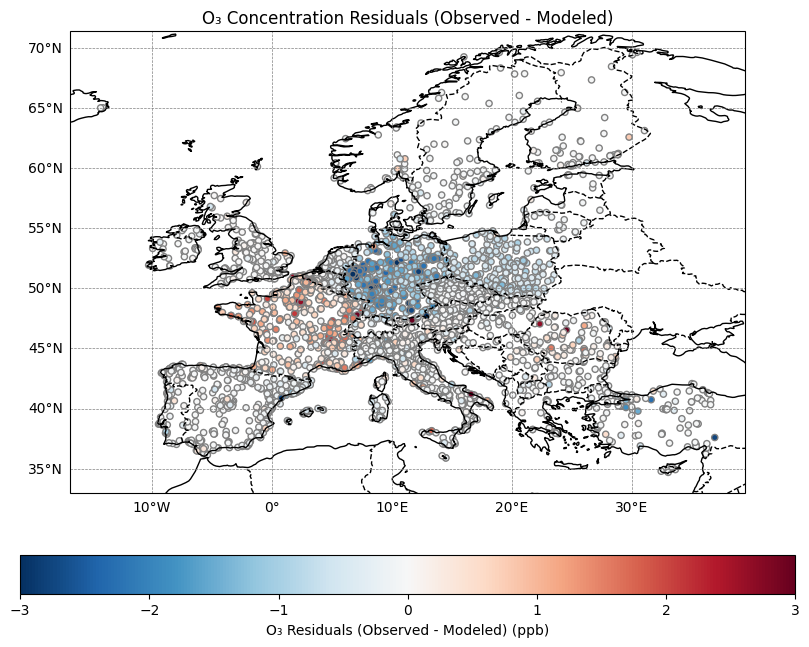

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseO3nearest_grid_idw.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -3
cbar_max = 3

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["O3_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("O₃ Residuals (Observed - Modeled) (ppb)")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


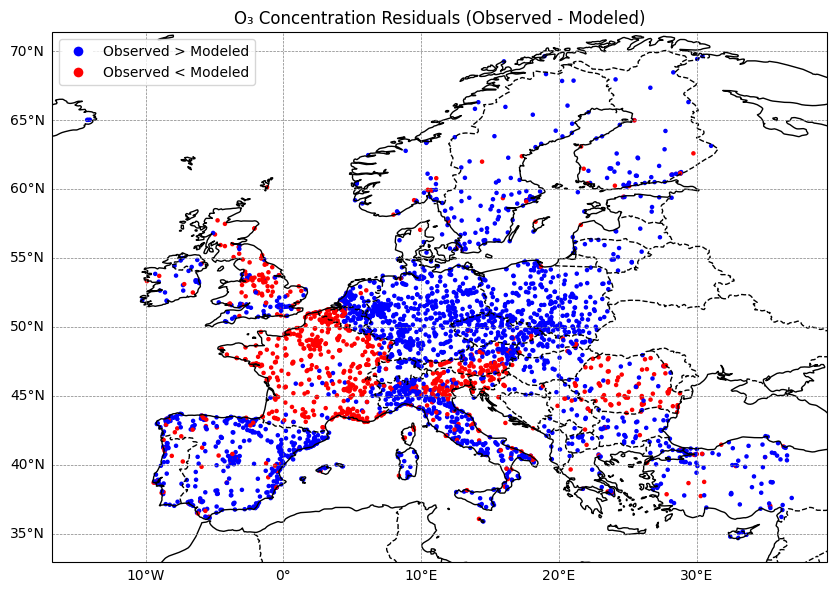

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseO3nearest_grid_idw.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["O3_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

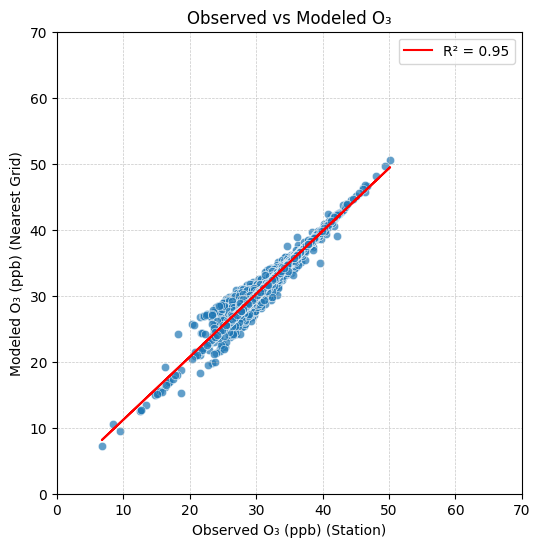

Mean Absolute Error (MAE): 0.53
Root Mean Squared Error (RMSE): 0.97


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("baseO3nearest_grid_idw.csv")

# Extract observed and modeled PM2.5 values
observed_O3 = stations["SURF_ppb_O3"]
modeled_O3 = stations["nearest_SURF_ppb_O3"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_O3, modeled_O3)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_O3, y=modeled_O3, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_O3, slope * observed_O3 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed O₃ (ppb) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled O₃ (ppb) (Nearest Grid)")
plt.title("Observed vs Modeled O₃")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_O3, modeled_O3)
rmse = np.sqrt(mean_squared_error(observed_O3, modeled_O3))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# $NO_{2}$

In [11]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm

# --- Load Data ---
nc_file_path = "BaseCase_PERT_NO2_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_NO2.csv"

# Load NetCDF Data
nc_data = xr.open_dataset(nc_file_path)
lon_values = nc_data["lon"].values  # Grid center longitudes
lat_values = nc_data["lat"].values  # Grid center latitudes
no2_grid = nc_data["SURF_ug_NO2"].values.squeeze()  # Remove time dimension

# Create grid points (centers)
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
no2_values = no2_grid.ravel()  # Flattened NO₂ values

# Load Station Data
station_data = pd.read_csv(csv_file_path)
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_observed_no2 = station_data["SURF_ug_NO2"].values
station_coords = np.column_stack((station_lons, station_lats))

# --- IDW Interpolation Function ---
def inverse_distance_weighting(station_coords, grid_points, pollutant_values, k=5, p=2):
    """Perform IDW interpolation from grid centers to station locations."""
    tree = cKDTree(grid_points)
    distances, indices = tree.query(station_coords, k=k)

    interpolated_values = np.zeros(len(station_coords))
    nearest_grid_lons = np.zeros(len(station_coords))
    nearest_grid_lats = np.zeros(len(station_coords))

    for i in range(len(station_coords)):
        d = distances[i]
        w = 1 / (d ** p)  # IDW weights
        w /= w.sum()  # Normalize weights
        interpolated_values[i] = np.sum(w * pollutant_values[indices[i]])

        # Assign nearest grid point
        nearest_grid_lons[i] = grid_points[indices[i][0], 0]
        nearest_grid_lats[i] = grid_points[indices[i][0], 1]

    return interpolated_values, nearest_grid_lons, nearest_grid_lats

# --- Hyperparameter Search (k-Fold CV) ---
p_values = np.arange(5, 15.1, 0.1).tolist()
k_values = np.arange(2, 5, 1).tolist()

best_mae, best_rmse = float("inf"), float("inf")
best_k, best_p = None, None
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

with tqdm(total=len(k_values) * len(p_values), desc="Hyperparameter Tuning") as pbar:
    for k in k_values:
        for p in p_values:
            mae_scores, rmse_scores = [], []

            for train_idx, test_idx in kf.split(station_coords):
                train_coords, test_coords = station_coords[train_idx], station_coords[test_idx]
                train_no2, test_no2 = station_observed_no2[train_idx], station_observed_no2[test_idx]

                # IDW Prediction
                predicted_no2, _, _ = inverse_distance_weighting(test_coords, grid_points, no2_values, k=k, p=p)

                # Compute Error Metrics
                mae_scores.append(mean_absolute_error(test_no2, predicted_no2))
                rmse_scores.append(np.sqrt(mean_squared_error(test_no2, predicted_no2)))

            # Average Scores
            avg_mae, avg_rmse = np.mean(mae_scores), np.mean(rmse_scores)
            results.append((k, p, avg_mae, avg_rmse))

            # Update Best Model
            if avg_rmse < best_rmse:
                best_rmse, best_mae, best_k, best_p = avg_rmse, avg_mae, k, p

            pbar.update(1)

# Save Results
df_results = pd.DataFrame(results, columns=["k", "p", "MAE", "RMSE"])
df_results.to_csv("idw_hyperparameter_results_NO2.csv", index=False)

# Apply Best Model to All Stations
final_no2, nearest_grid_lons, nearest_grid_lats = inverse_distance_weighting(
    station_coords, grid_points, no2_values, k=best_k, p=best_p
)

# Create grid cell index as a tuple
grid_cell_indices = list(zip(nearest_grid_lons, nearest_grid_lats))

# --- Save Final Results ---
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": nearest_grid_lons,
    "nearest_grid_lat": nearest_grid_lats,
    "grid_cell_index": grid_cell_indices,
    "SURF_ug_NO2": station_observed_no2,
    "nearest_SURF_ug_NO2": final_no2
})

df_matched.to_csv("baseNO2nearest_grid_idw.csv", index=False)

# --- Check for Duplicate Grid Cells ---
duplicate_grid_cells = df_matched.groupby(["grid_cell_index"]).size()
shared_grid_cells = duplicate_grid_cells[duplicate_grid_cells > 1]

if not shared_grid_cells.empty:
    print(f"Warning: {len(shared_grid_cells)} grid cells are shared by multiple stations.")
    duplicated_stations = df_matched[df_matched["grid_cell_index"].isin(shared_grid_cells.index)]
    duplicated_stations.to_csv("duplicated_stations_NO2.csv", index=False)
    print("Duplicated stations saved to duplicated_stations_NO2.csv")
else:
    print("All stations have unique grid cells. No duplicates found.")

# Output Best Model
print(f"Best Model Found: k = {best_k}, p = {best_p}, MAE = {best_mae:.4f}, RMSE = {best_rmse:.4f}")


Hyperparameter Tuning: 100%|██████████| 303/303 [04:21<00:00,  1.16it/s]


All stations have unique grid cells. No duplicates found.
Best Model Found: k = 2, p = 14.999999999999964, MAE = 1.2125, RMSE = 2.2594


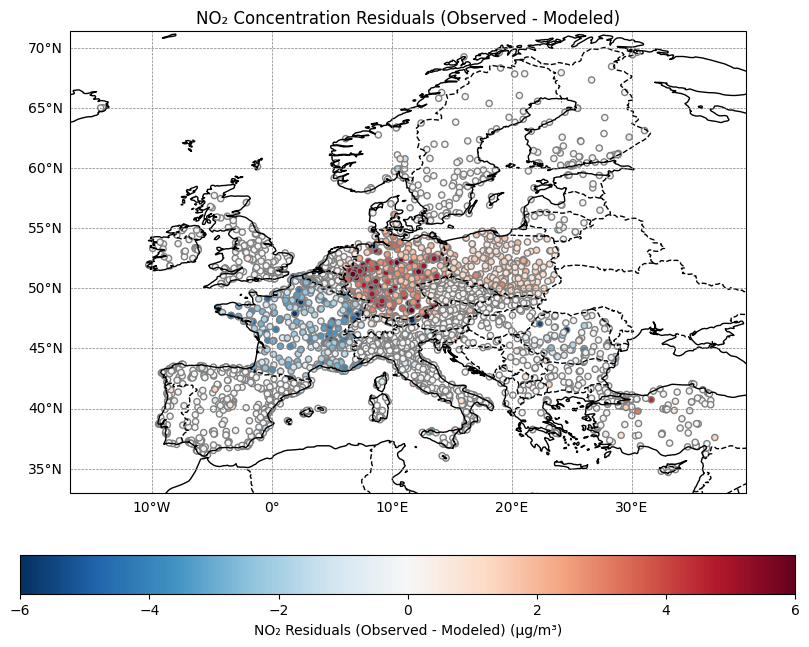

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseNO2nearest_grid_idw.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["NO2_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("NO₂ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


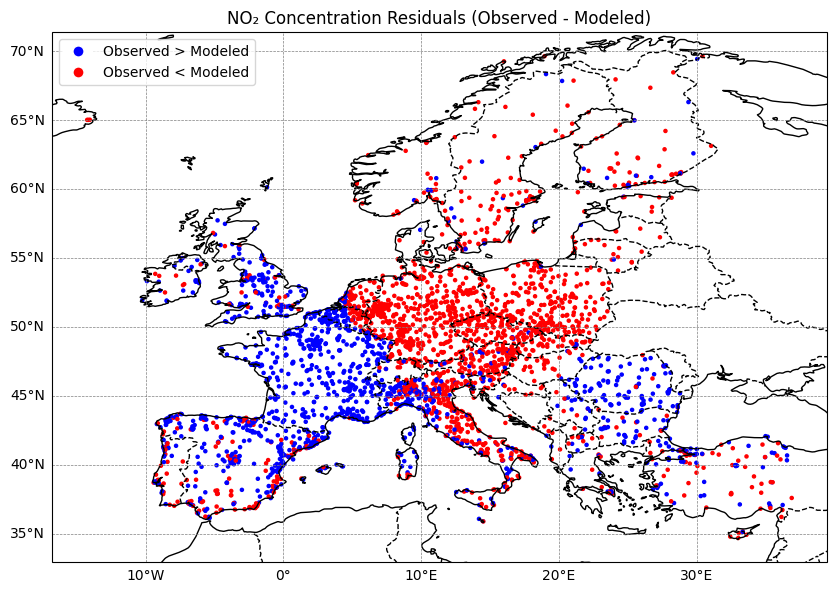

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("baseNO2nearest_grid_idw.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["NO2_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


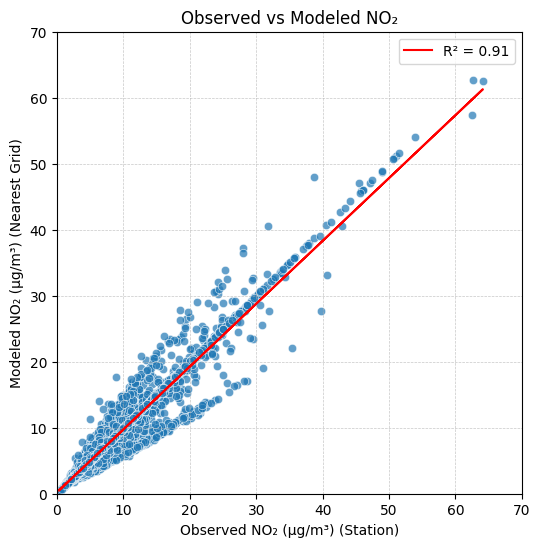

Mean Absolute Error (MAE): 1.21
Root Mean Squared Error (RMSE): 2.26


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("baseNO2nearest_grid_idw.csv")

# Extract observed and modeled PM2.5 values
observed_NO2 = stations["SURF_ug_NO2"]
modeled_NO2 = stations["nearest_SURF_ug_NO2"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_NO2, modeled_NO2)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_NO2, y=modeled_NO2, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_NO2, slope * observed_NO2 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed NO₂ (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled NO₂ (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled NO₂")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_NO2, modeled_NO2)
rmse = np.sqrt(mean_squared_error(observed_NO2, modeled_NO2))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# $PM_{2.5}$

In [5]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tqdm import tqdm

# --- Load Data ---
nc_file_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_PM25_rh50.csv"

# Load NetCDF Data
nc_data = xr.open_dataset(nc_file_path)
lon_values = nc_data["lon"].values  # Grid center longitudes
lat_values = nc_data["lat"].values  # Grid center latitudes
pm25_grid = nc_data["SURF_ug_PM25_rh50"].values.squeeze()  # Remove time dimension

# Create grid points (centers)
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
pm25_values = pm25_grid.ravel()  # Flattened PM₂.₅ values

# Load Station Data
station_data = pd.read_csv(csv_file_path)
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_observed_pm25 = station_data["SURF_ug_PM25_rh50"].values
station_coords = np.column_stack((station_lons, station_lats))

# --- IDW Interpolation Function ---
def inverse_distance_weighting(station_coords, grid_points, pm25_values, k=5, p=2):
    """Perform IDW interpolation from grid centers to station locations."""
    tree = cKDTree(grid_points)
    distances, indices = tree.query(station_coords, k=k)

    interpolated_pm25 = np.zeros(len(station_coords))
    nearest_grid_lons = np.zeros(len(station_coords))
    nearest_grid_lats = np.zeros(len(station_coords))

    for i in range(len(station_coords)):
        d = distances[i]
        w = 1 / (d ** p)  # IDW weights
        w /= w.sum()  # Normalize weights
        interpolated_pm25[i] = np.sum(w * pm25_values[indices[i]])

        # Assign nearest grid point
        nearest_grid_lons[i] = grid_points[indices[i][0], 0]
        nearest_grid_lats[i] = grid_points[indices[i][0], 1]

    return interpolated_pm25, nearest_grid_lons, nearest_grid_lats

# --- Hyperparameter Search (k-Fold CV) ---
p_values = np.arange(5, 15.1, 0.1).tolist()
k_values = np.arange(2, 5, 1).tolist()

best_mae, best_rmse = float("inf"), float("inf")
best_k, best_p = None, None
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

with tqdm(total=len(k_values) * len(p_values), desc="Hyperparameter Tuning") as pbar:
    for k in k_values:
        for p in p_values:
            mae_scores, rmse_scores = [], []

            for train_idx, test_idx in kf.split(station_coords):
                train_coords, test_coords = station_coords[train_idx], station_coords[test_idx]
                train_pm25, test_pm25 = station_observed_pm25[train_idx], station_observed_pm25[test_idx]

                # IDW Prediction
                predicted_pm25, _, _ = inverse_distance_weighting(test_coords, grid_points, pm25_values, k=k, p=p)

                # Compute Error Metrics
                mae_scores.append(mean_absolute_error(test_pm25, predicted_pm25))
                rmse_scores.append(np.sqrt(mean_squared_error(test_pm25, predicted_pm25)))

            # Average Scores
            avg_mae, avg_rmse = np.mean(mae_scores), np.mean(rmse_scores)
            results.append((k, p, avg_mae, avg_rmse))

            # Update Best Model
            if avg_rmse < best_rmse:
                best_rmse, best_mae, best_k, best_p = avg_rmse, avg_mae, k, p

            pbar.update(1)

# Save Results
df_results = pd.DataFrame(results, columns=["k", "p", "MAE", "RMSE"])
df_results.to_csv("idw_hyperparameter_results.csv", index=False)

# Apply Best Model to All Stations
final_pm25, nearest_grid_lons, nearest_grid_lats = inverse_distance_weighting(
    station_coords, grid_points, pm25_values, k=best_k, p=best_p
)

# Create grid cell index as a tuple
grid_cell_indices = list(zip(nearest_grid_lons, nearest_grid_lats))

# --- Save Final Results in Required Format ---
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": nearest_grid_lons,
    "nearest_grid_lat": nearest_grid_lats,
    "grid_cell_index": grid_cell_indices,
    "SURF_ug_PM25_rh50": station_observed_pm25,
    "nearest_SURF_ug_PM25_rh50": final_pm25
})

# Ensure exact format order
df_matched = df_matched[[
    "lon", "lat", "nearest_grid_lon", "nearest_grid_lat",
    "grid_cell_index", "SURF_ug_PM25_rh50", "nearest_SURF_ug_PM25_rh50"
]]

# Save file with the new name
df_matched.to_csv("basePM25nearest_grid_idw.csv", index=False)

# --- Check for Duplicate Grid Cells ---
duplicate_grid_cells = df_matched.groupby(["grid_cell_index"]).size()
shared_grid_cells = duplicate_grid_cells[duplicate_grid_cells > 1]

if not shared_grid_cells.empty:
    print(f"Warning: {len(shared_grid_cells)} grid cells are shared by multiple stations.")

    # Retrieve the stations that share grid cells
    duplicated_stations = df_matched[df_matched["grid_cell_index"].isin(shared_grid_cells.index)]

    # Save the list of duplicated stations for further analysis
    duplicated_stations.to_csv("duplicated_stations_idw.csv", index=False)
    print("Duplicated stations saved to duplicated_stations_idw.csv")
else:
    print("All stations have unique grid cells. No duplicates found.")

# Output Best Model
print(f"Best Model Found: k = {best_k}, p = {best_p}, MAE = {best_mae:.4f}, RMSE = {best_rmse:.4f}")


Hyperparameter Tuning: 100%|██████████| 303/303 [04:22<00:00,  1.16it/s]


All stations have unique grid cells. No duplicates found.
Best Model Found: k = 2, p = 14.999999999999964, MAE = 0.9130, RMSE = 1.8353


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


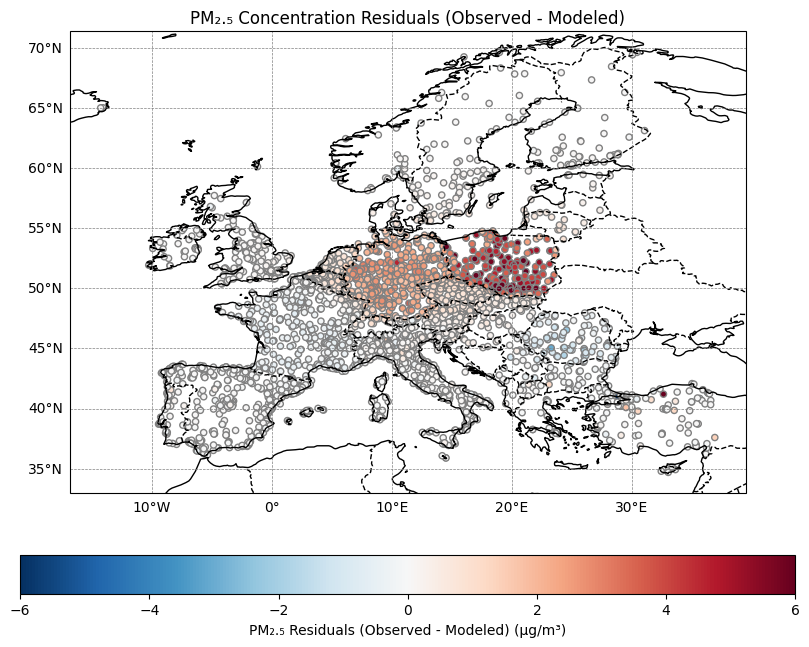

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("basePM25nearest_grid_idw.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["PM25_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors="grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("PM₂.₅ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

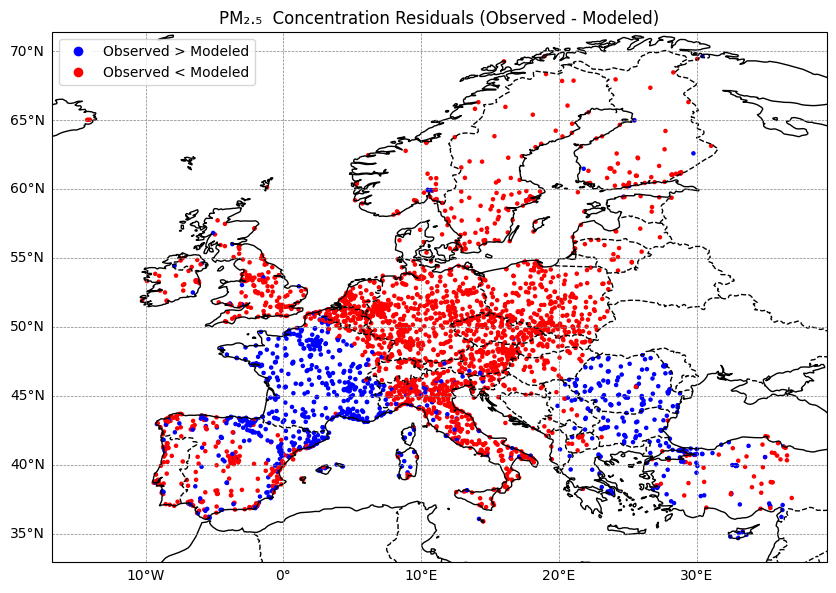

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("basePM25nearest_grid_idw.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["PM25_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("PM₂.₅  Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


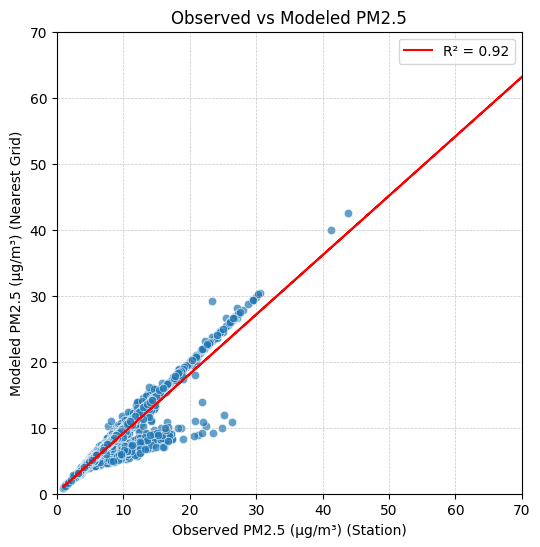

Mean Absolute Error (MAE): 0.91
Root Mean Squared Error (RMSE): 1.85


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("basePM25nearest_grid_idw.csv")

# Extract observed and modeled PM2.5 values
observed_pm25 = stations["SURF_ug_PM25_rh50"]
modeled_pm25 = stations["nearest_SURF_ug_PM25_rh50"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_pm25, modeled_pm25)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_pm25, y=modeled_pm25, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_pm25, slope * observed_pm25 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed PM2.5 (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled PM2.5 (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled PM2.5")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_pm25, modeled_pm25)
rmse = np.sqrt(mean_squared_error(observed_pm25, modeled_pm25))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
